# Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration (Refactored)
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
**Refactored version to eliminate redundant analyses and streamline the workflow.**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


=============================================================================
CONFIGURATION AND DATA LOADING
=============================================================================

In [5]:
# Configuration parameters
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """Load and validate data from SQLite database for a specific site."""
    try:
        conn = sqlite3.connect(db_path)
        
        # Check if site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Main query
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, m.volume_m3,
            m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = ? AND
              m.ec_ftir IS NOT NULL AND
              m.oc_ftir IS NOT NULL AND
              m.fabs IS NOT NULL
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn, params=(site_code,))
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)


Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


=============================================================================
DATA PREPROCESSING AND QUALITY CONTROL
=============================================================================

In [6]:
def preprocess_data(df, site_code):
    """Complete data preprocessing pipeline."""
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Handle values below MDL (conservative approach: replace with MDL/2)
    df_processed = df.copy()
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), ('oc_ftir', 'oc_ftir_mdl'), ('fabs', 'fabs_mdl')]:
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        if below_count > 0:
            df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
            print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
    
    # Calculate derived metrics
    df_processed['oc_ec_ratio'] = df_processed['oc_ftir'] / df_processed['ec_ftir']
    df_processed['mac'] = df_processed['fabs'] / df_processed['ec_ftir']
    df_processed['month'] = df_processed['sample_date'].dt.month
    
    # Ethiopian season mapping
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_processed['season'] = df_processed['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values
    df_clean = df_processed[
        (df_processed['mac'] < 50) & 
        (df_processed['oc_ec_ratio'] < 20)
    ]
    
    if len(df_clean) < len(df_processed):
        print(f"Removed {len(df_processed) - len(df_clean)} samples with extreme values")
    
    return df_clean

# Preprocess the data
data_processed = preprocess_data(data, SITE_OF_INTEREST)


===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC: 0.6% below MDL
Fabs: 0.0% below MDL
Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values



ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - YOUR_SITE_CODE
Data: 161 samples
EC range: 1.6-10.5 μg/m³
Fabs range: 28.1-74.2 Mm⁻¹

MAC CALCULATION METHODS SUMMARY
Method 1 MAC (Mean of Ratios): 11.151 m²/g
Method 2 MAC (Ratio of Means): 10.092 m²/g
Method 3 MAC (Regression): 4.198 m²/g, Intercept: 27.634
Method 4 MAC (Origin Regression): 9.177 m²/g

GENERATING PREDICTIONS FROM EACH METHOD
Method 1 predictions: Fabs = 11.151 × EC
Range: 18.1 to 117.5 Mm⁻¹
Method 2 predictions: Fabs = 10.092 × EC
Range: 16.4 to 106.3 Mm⁻¹
Method 3 predictions: Fabs = 4.198 × EC + 27.634
Range: 34.5 to 71.9 Mm⁻¹
Method 4 predictions: Fabs = 9.177 × EC
Range: 14.9 to 96.7 Mm⁻¹

MANUAL R² CALCULATION FOR EACH METHOD
R² = [correlation(EC_original, Fabs_predicted)]²

📊 Method 1: Mean of Individual Ratios
   Correlation(EC, Fabs_pred) = 1.000000
   R² = r² = 1.000000
   p-value = 0.00e+00

📊 Method 2: Ratio of Means
   Correlation(EC, Fabs_pred) = 1.000000
   R² = r² = 1.000000
   p-value = 0.00e+00


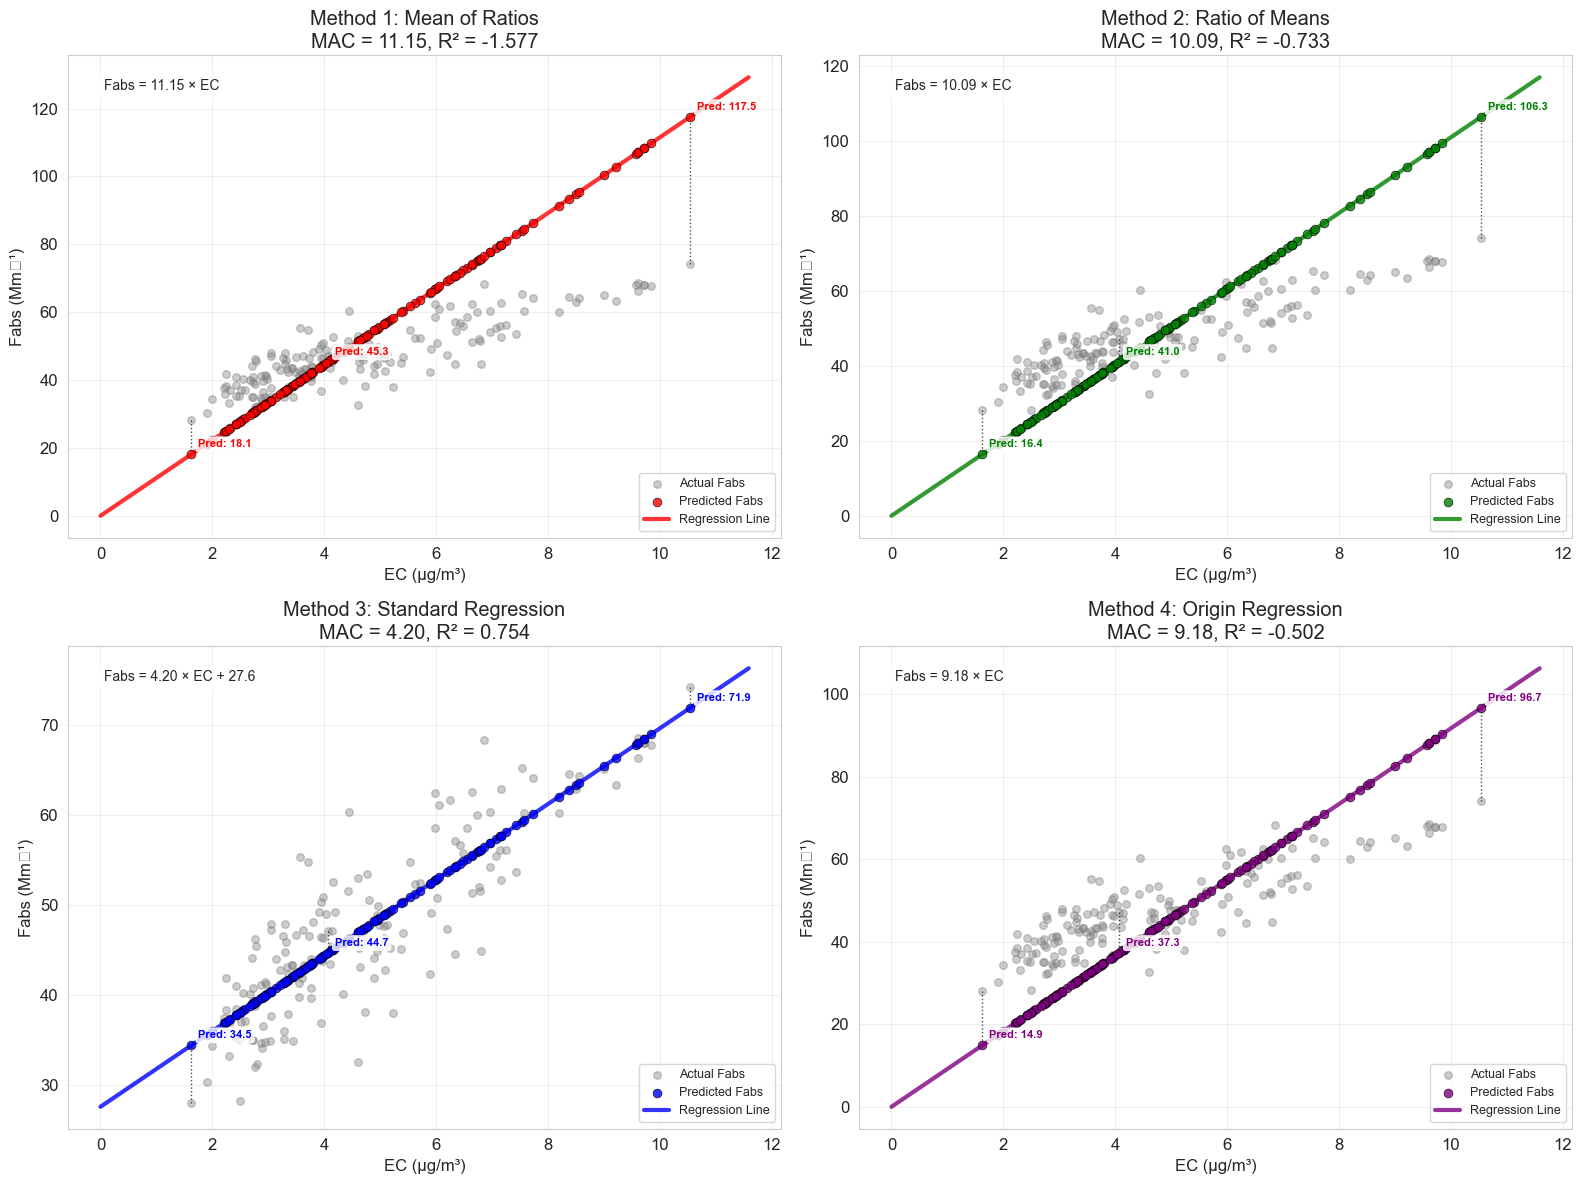


BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM
🔍 THE INTERCEPT ISSUE:
Method 3 (best regression): Fabs = 4.20 × EC + 27.6
Problem: When EC = 0, Fabs = 27.6 Mm⁻¹ (not zero!)
This 27.6 Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)

💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:

1️⃣ SOLUTION 1: Baseline-Corrected Method 3
   Formula: BC = (Fabs - 27.6) / 4.20
   Logic: Subtract non-BC absorption, then apply MAC
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.15 μg/m³
     Correlation: r = 0.868

2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)
   Formula: BC = Fabs / 10.09
   Logic: No intercept, physically meaningful zero point
   Performance vs FTIR EC:
     BC mean: 4.69 μg/m³
     Bias: 0.00 μg/m³
     RMSE: 1.27 μg/m³
     Correlation: r = 0.868

3️⃣ SOLUTION 3: Hybrid Approach
   Use Method 3 MAC but apply threshold
   Formula: BC = max(0, (Fabs - threshold) / 4.20)
   50% baseline (13.8 Mm⁻¹): Bias = 3.29, RMSE = 3

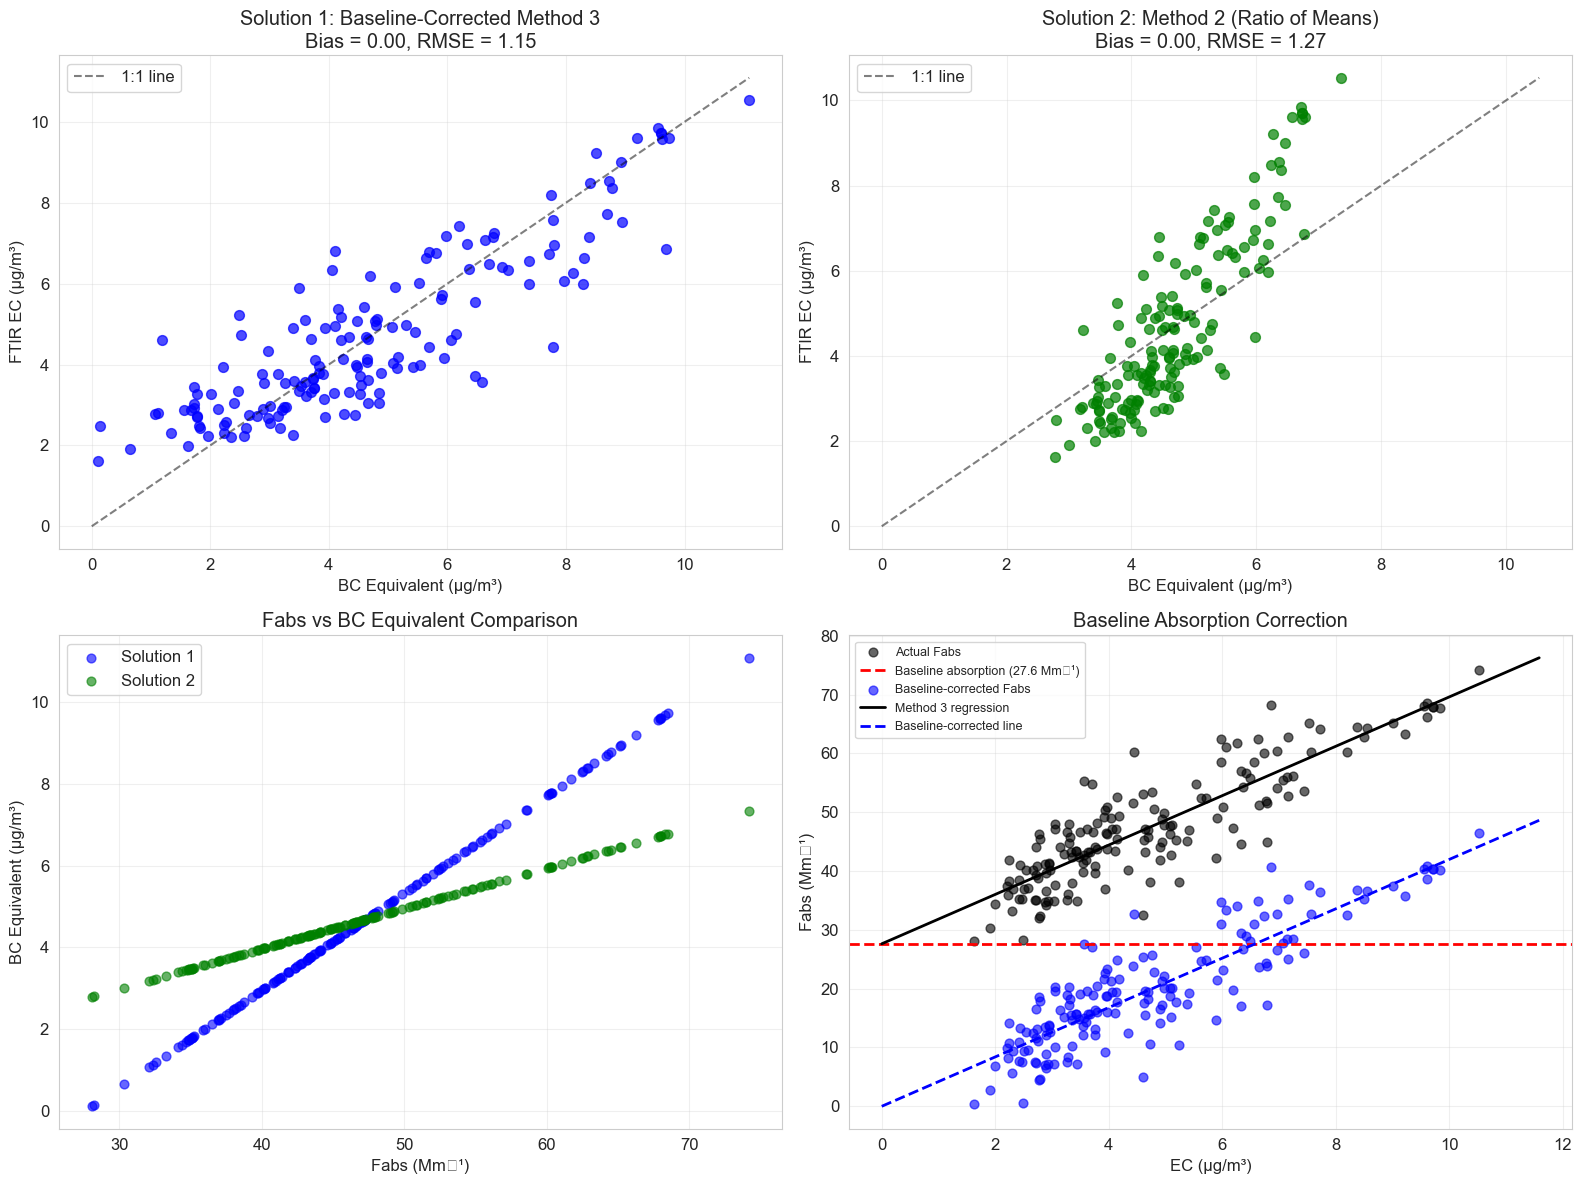


RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS
🏆 RANKING BY PERFORMANCE:
1. Solution 1 (Baseline-corrected)
   Bias: 0.00 μg/m³, RMSE: 1.15 μg/m³, r: 0.868
   ✅ RECOMMENDED APPROACH

2. Solution 2 (Method 2)
   Bias: 0.00 μg/m³, RMSE: 1.27 μg/m³, r: 0.868

📝 PRACTICAL IMPLEMENTATION:
For HIPS measurements, use:
  BC = max(0, (Fabs - 27.6) / 4.20)
  This accounts for 27.6 Mm⁻¹ baseline absorption
Function defined successfully!
To run the analysis, use:
enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'your_site_code')

Where:
- your_dataframe should contain 'ec_ftir' and 'fabs' columns
- your_site_code is a string identifier for your site


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

def enhanced_mac_visualization_with_predictions(df, site_code):
    """
    Enhanced visualization showing predicted values on regression lines
    and addressing the intercept issue for BC calculations
    """
    
    print(f"\n{'='*80}")
    print(f"ENHANCED MAC ANALYSIS WITH BC CALCULATION SOLUTIONS - {site_code}")
    print(f"{'='*80}")
    
    # Original data - moved before data summary
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    # Data summary
    print(f"Data: {len(df)} samples")
    print(f"EC range: {ec_original.min():.1f}-{ec_original.max():.1f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.1f}-{fabs_original.max():.1f} Mm⁻¹")
    
    # Calculate MAC values for each method
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Generate predictions
    fabs_pred_method1 = mac_method1 * ec_original
    fabs_pred_method2 = mac_method2 * ec_original
    fabs_pred_method3 = mac_method3 * ec_original + intercept_method3
    fabs_pred_method4 = mac_method4 * ec_original
    
    methods_data = [
        ("Method 1: Mean of Ratios", mac_method1, 0, fabs_pred_method1, 'red'),
        ("Method 2: Ratio of Means", mac_method2, 0, fabs_pred_method2, 'green'),
        ("Method 3: Standard Regression", mac_method3, intercept_method3, fabs_pred_method3, 'blue'),
        ("Method 4: Origin Regression", mac_method4, 0, fabs_pred_method4, 'purple')
    ]
    
    # =============================================================================
    # Method Summary
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MAC CALCULATION METHODS SUMMARY")
    print(f"{'='*80}")
    
    print(f"Method 1 MAC (Mean of Ratios): {mac_method1:.3f} m²/g")
    print(f"Method 2 MAC (Ratio of Means): {mac_method2:.3f} m²/g")
    print(f"Method 3 MAC (Regression): {mac_method3:.3f} m²/g, Intercept: {intercept_method3:.3f}")
    print(f"Method 4 MAC (Origin Regression): {mac_method4:.3f} m²/g")
    
    print(f"\n{'='*80}")
    print(f"GENERATING PREDICTIONS FROM EACH METHOD")
    print(f"{'='*80}")
    
    print(f"Method 1 predictions: Fabs = {mac_method1:.3f} × EC")
    print(f"Range: {fabs_pred_method1.min():.1f} to {fabs_pred_method1.max():.1f} Mm⁻¹")
    
    print(f"Method 2 predictions: Fabs = {mac_method2:.3f} × EC")
    print(f"Range: {fabs_pred_method2.min():.1f} to {fabs_pred_method2.max():.1f} Mm⁻¹")
    
    print(f"Method 3 predictions: Fabs = {mac_method3:.3f} × EC + {intercept_method3:.3f}")
    print(f"Range: {fabs_pred_method3.min():.1f} to {fabs_pred_method3.max():.1f} Mm⁻¹")
    
    print(f"Method 4 predictions: Fabs = {mac_method4:.3f} × EC")
    print(f"Range: {fabs_pred_method4.min():.1f} to {fabs_pred_method4.max():.1f} Mm⁻¹")
    
    # =============================================================================
    # Manual R² calculations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"MANUAL R² CALCULATION FOR EACH METHOD")
    print(f"R² = [correlation(EC_original, Fabs_predicted)]²")
    print(f"{'='*80}")
    
    # Calculate correlations and R² for each method
    correlations = []
    r_squared_values = []
    p_values = []
    
    predictions_list = [fabs_pred_method1, fabs_pred_method2, fabs_pred_method3, fabs_pred_method4]
    method_names = ["Method 1: Mean of Individual Ratios", "Method 2: Ratio of Means", 
                   "Method 3: Standard Linear Regression", "Method 4: Origin Regression"]
    mac_values = [mac_method1, mac_method2, mac_method3, mac_method4]
    
    for i, (pred, name, mac) in enumerate(zip(predictions_list, method_names, mac_values)):
        r, p = pearsonr(ec_original, pred)
        r_squared = r**2
        correlations.append(r)
        r_squared_values.append(r_squared)
        p_values.append(p)
        
        print(f"\n📊 {name}")
        print(f"   Correlation(EC, Fabs_pred) = {r:.6f}")
        print(f"   R² = r² = {r_squared:.6f}")
        print(f"   p-value = {p:.2e}")
    
    # Reference comparison
    r_actual, p_actual = pearsonr(ec_original, fabs_original)
    r2_actual = r_actual**2
    
    print(f"\n🔍 REFERENCE COMPARISON:")
    print(f"   Actual correlation(EC, Fabs_original) = {r_actual:.6f}")
    print(f"   Actual R² = {r2_actual:.6f}")
    print(f"   This is the benchmark - how close do our methods get?")
    
    # Summary table
    print(f"\n{'='*100}")
    print(f"SUMMARY TABLE - MANUAL R² CALCULATION RESULTS")
    print(f"{'='*100}")
    print(f"{'Method':<30} {'MAC':<8} {'Correlation r':<12} {'R²':<10} {'Difference from Actual':<20}")
    print(f"{'='*100}")
    
    method_short_names = ["Method 1: Mean of Ratios", "Method 2: Ratio of Means", 
                         "Method 3: Standard Regression", "Method 4: Origin Regression"]
    
    for i in range(4):
        diff_from_actual = r_squared_values[i] - r2_actual
        print(f"{method_short_names[i]:<30} {mac_values[i]:<8.3f} {correlations[i]:<12.6f} {r_squared_values[i]:<10.6f} {diff_from_actual:<20.6f}")
    
    print(f"{'Actual (EC vs Fabs)':<30} {'N/A':<8} {r_actual:<12.6f} {r2_actual:<10.6f} {0.000000:<20.6f}")
    print(f"{'='*100}")
    
    # =============================================================================
    # Enhanced visualization with predicted values on lines
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, (method_name, mac, intercept, fabs_pred, color) in enumerate(methods_data):
        ax = axes[i//2, i%2]
        
        # Plot actual data
        ax.scatter(ec_original, fabs_original, alpha=0.4, s=30, color='gray', 
                  label='Actual Fabs', zorder=1)
        
        # Plot predicted points ON THE LINE
        ax.scatter(ec_original, fabs_pred, alpha=0.8, s=40, color=color, 
                  label='Predicted Fabs', zorder=3, edgecolors='black', linewidth=0.5)
        
        # Plot regression line
        ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
        fabs_line = mac * ec_line + intercept
        ax.plot(ec_line, fabs_line, color=color, linewidth=3, alpha=0.8, 
                label=f'Regression Line', zorder=2)
        
        # Highlight a few specific predictions with annotations
        # Choose 3 representative points: low, medium, high EC
        indices = [np.argmin(ec_original), 
                  np.argmin(np.abs(ec_original - np.median(ec_original))),
                  np.argmax(ec_original)]
        
        for idx in indices:
            ec_val = ec_original[idx]
            fabs_actual = fabs_original[idx]
            fabs_predicted = fabs_pred[idx]
            
            # Draw line from actual to predicted
            ax.plot([ec_val, ec_val], [fabs_actual, fabs_predicted], 
                   color='black', linestyle=':', alpha=0.7, linewidth=1)
            
            # Annotate the predicted value
            ax.annotate(f'Pred: {fabs_predicted:.1f}', 
                       xy=(ec_val, fabs_predicted), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, color=color, weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Calculate regression R²
        ss_res = np.sum((fabs_original - fabs_pred)**2)
        ss_tot = np.sum((fabs_original - np.mean(fabs_original))**2)
        regression_r2 = 1 - (ss_res / ss_tot)
        
        ax.set_xlabel('EC (μg/m³)')
        ax.set_ylabel('Fabs (Mm⁻¹)')
        # Fixed title formatting - using proper line breaks
        ax.set_title(f'{method_name}\nMAC = {mac:.2f}, R² = {regression_r2:.3f}')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add equation with intercept handling
        if intercept != 0:
            equation = f'Fabs = {mac:.2f} × EC + {intercept:.1f}'
        else:
            equation = f'Fabs = {mac:.2f} × EC'
        
        ax.text(0.05, 0.95, equation, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # BC Calculation Solutions - Addressing the Intercept Problem
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"BC CALCULATION SOLUTIONS - HANDLING THE INTERCEPT PROBLEM")
    print(f"{'='*80}")
    
    print(f"🔍 THE INTERCEPT ISSUE:")
    print(f"Method 3 (best regression): Fabs = {mac_method3:.2f} × EC + {intercept_method3:.1f}")
    print(f"Problem: When EC = 0, Fabs = {intercept_method3:.1f} Mm⁻¹ (not zero!)")
    print(f"This {intercept_method3:.1f} Mm⁻¹ represents non-BC absorption (brown carbon, dust, etc.)")
    
    print(f"\n💡 SOLUTION OPTIONS FOR BC EQUIVALENT CALCULATIONS:")
    
    # =============================================================================
    # Solution 1: Baseline-Corrected Method 3
    # =============================================================================
    
    print(f"\n1️⃣ SOLUTION 1: Baseline-Corrected Method 3")
    print(f"   Formula: BC = (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f}")
    print(f"   Logic: Subtract non-BC absorption, then apply MAC")
    
    # Calculate baseline-corrected BC
    fabs_corrected = np.maximum(fabs_original - intercept_method3, 0)  # Don't go negative
    bc_corrected = fabs_corrected / mac_method3
    
    # Performance vs FTIR EC
    bias_corrected = np.mean(bc_corrected - ec_original)
    rmse_corrected = np.sqrt(np.mean((bc_corrected - ec_original)**2))
    r_corrected, _ = pearsonr(bc_corrected, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_corrected.mean():.2f} μg/m³")
    print(f"     Bias: {bias_corrected:.2f} μg/m³")
    print(f"     RMSE: {rmse_corrected:.2f} μg/m³")
    print(f"     Correlation: r = {r_corrected:.3f}")
    
    # =============================================================================
    # Solution 2: Use Method 2 (Ratio of Means) - No Intercept Issue
    # =============================================================================
    
    print(f"\n2️⃣ SOLUTION 2: Use Method 2 (Ratio of Means)")
    print(f"   Formula: BC = Fabs / {mac_method2:.2f}")
    print(f"   Logic: No intercept, physically meaningful zero point")
    
    bc_method2 = fabs_original / mac_method2
    bias_method2 = np.mean(bc_method2 - ec_original)
    rmse_method2 = np.sqrt(np.mean((bc_method2 - ec_original)**2))
    r_method2, _ = pearsonr(bc_method2, ec_original)
    
    print(f"   Performance vs FTIR EC:")
    print(f"     BC mean: {bc_method2.mean():.2f} μg/m³")
    print(f"     Bias: {bias_method2:.2f} μg/m³")
    print(f"     RMSE: {rmse_method2:.2f} μg/m³")
    print(f"     Correlation: r = {r_method2:.3f}")
    
    # =============================================================================
    # Solution 3: Hybrid Approach
    # =============================================================================
    
    print(f"\n3️⃣ SOLUTION 3: Hybrid Approach")
    print(f"   Use Method 3 MAC but apply threshold")
    print(f"   Formula: BC = max(0, (Fabs - threshold) / {mac_method3:.2f})")
    
    # Try different thresholds
    thresholds = [intercept_method3 * 0.5, intercept_method3 * 0.75, intercept_method3]
    threshold_names = ["50% baseline", "75% baseline", "Full baseline"]
    
    for threshold, name in zip(thresholds, threshold_names):
        fabs_adj = np.maximum(fabs_original - threshold, 0)
        bc_hybrid = fabs_adj / mac_method3
        bias_hybrid = np.mean(bc_hybrid - ec_original)
        rmse_hybrid = np.sqrt(np.mean((bc_hybrid - ec_original)**2))
        
        print(f"   {name} ({threshold:.1f} Mm⁻¹): Bias = {bias_hybrid:.2f}, RMSE = {rmse_hybrid:.2f}")
    
    # =============================================================================
    # Comparison visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Solution 1: Baseline-corrected Method 3
    ax1 = axes[0, 0]
    ax1.scatter(bc_corrected, ec_original, alpha=0.7, s=50, color='blue')
    ax1.plot([0, max(bc_corrected.max(), ec_original.max())], [0, max(bc_corrected.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax1.set_xlabel('BC Equivalent (μg/m³)')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax1.set_title(f'Solution 1: Baseline-Corrected Method 3\nBias = {bias_corrected:.2f}, RMSE = {rmse_corrected:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Solution 2: Method 2
    ax2 = axes[0, 1]
    ax2.scatter(bc_method2, ec_original, alpha=0.7, s=50, color='green')
    ax2.plot([0, max(bc_method2.max(), ec_original.max())], [0, max(bc_method2.max(), ec_original.max())], 
             'k--', alpha=0.5, label='1:1 line')
    ax2.set_xlabel('BC Equivalent (μg/m³)')
    ax2.set_ylabel('FTIR EC (μg/m³)')
    # Fixed title formatting
    ax2.set_title(f'Solution 2: Method 2 (Ratio of Means)\nBias = {bias_method2:.2f}, RMSE = {rmse_method2:.2f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Fabs vs BC comparison
    ax3 = axes[1, 0]
    ax3.scatter(fabs_original, bc_corrected, alpha=0.6, s=40, color='blue', label='Solution 1')
    ax3.scatter(fabs_original, bc_method2, alpha=0.6, s=40, color='green', label='Solution 2')
    ax3.set_xlabel('Fabs (Mm⁻¹)')
    ax3.set_ylabel('BC Equivalent (μg/m³)')
    ax3.set_title('Fabs vs BC Equivalent Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Baseline absorption demonstration
    ax4 = axes[1, 1]
    ax4.scatter(ec_original, fabs_original, alpha=0.6, s=40, color='black', label='Actual Fabs')
    ax4.axhline(intercept_method3, color='red', linestyle='--', linewidth=2, 
                label=f'Baseline absorption ({intercept_method3:.1f} Mm⁻¹)')
    ax4.scatter(ec_original, fabs_corrected, alpha=0.6, s=40, color='blue', 
                label='Baseline-corrected Fabs')
    
    ec_line = np.linspace(0, ec_original.max() * 1.1, 100)
    ax4.plot(ec_line, mac_method3 * ec_line + intercept_method3, 'black', linewidth=2, 
             label='Method 3 regression')
    ax4.plot(ec_line, mac_method3 * ec_line, 'blue', linewidth=2, linestyle='--',
             label='Baseline-corrected line')
    
    ax4.set_xlabel('EC (μg/m³)')
    ax4.set_ylabel('Fabs (Mm⁻¹)')
    ax4.set_title('Baseline Absorption Correction')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # Recommendations
    # =============================================================================
    
    print(f"\n{'='*80}")
    print(f"RECOMMENDATIONS FOR BC EQUIVALENT CALCULATIONS")
    print(f"{'='*80}")
    
    solutions = [
        ("Solution 1 (Baseline-corrected)", bias_corrected, rmse_corrected, r_corrected),
        ("Solution 2 (Method 2)", bias_method2, rmse_method2, r_method2)
    ]
    
    # Rank by performance
    solutions.sort(key=lambda x: abs(x[1]) + x[2])  # Sort by |bias| + RMSE
    
    print(f"🏆 RANKING BY PERFORMANCE:")
    for i, (name, bias, rmse, r) in enumerate(solutions, 1):
        print(f"{i}. {name}")
        print(f"   Bias: {bias:.2f} μg/m³, RMSE: {rmse:.2f} μg/m³, r: {r:.3f}")
        if i == 1:
            print(f"   ✅ RECOMMENDED APPROACH")
        print()
    
    print(f"📝 PRACTICAL IMPLEMENTATION:")
    best_solution = solutions[0][0]
    if "Solution 1" in best_solution:
        print(f"For HIPS measurements, use:")
        print(f"  BC = max(0, (Fabs - {intercept_method3:.1f}) / {mac_method3:.2f})")
        print(f"  This accounts for {intercept_method3:.1f} Mm⁻¹ baseline absorption")
    else:
        print(f"For HIPS measurements, use:")
        print(f"  BC = Fabs / {mac_method2:.2f}")
        print(f"  This avoids the intercept issue entirely")
    
    return {
        'methods_data': methods_data,
        'bc_corrected': bc_corrected,
        'bc_method2': bc_method2,
        'best_solution': solutions[0],
        'intercept': intercept_method3
    }

# Run the enhanced analysis
# Comment out the automatic execution - user should call the function manually
# with their specific data variable and site code

# Example usage:
enhanced_results = enhanced_mac_visualization_with_predictions(data_processed, 'YOUR_SITE_CODE')

print("Function defined successfully!")
print("To run the analysis, use:")
print("enhanced_results = enhanced_mac_visualization_with_predictions(your_dataframe, 'your_site_code')")
print("\nWhere:")
print("- your_dataframe should contain 'ec_ftir' and 'fabs' columns")
print("- your_site_code is a string identifier for your site")